In [1]:
import pandas as pd
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import statsmodels.api as sm
import ruptures as rpt

In [2]:
data = pd.read_csv("./cleaned/usdrub.csv")

In [3]:
data.drop(columns=["Unnamed: 0"], inplace=True)

In [4]:
data.head()

,date,open,high,low,close,vol
0,2014-02-06,34.8934,34.9337,34.5848,34.7102,7669
1,2014-02-07,34.7300,34.8300,34.5300,34.7500,10
2,2014-05-05,35.7747,35.8635,35.6700,35.7100,1564
3,2014-10-07,39.7165,39.9751,39.6550,39.8873,376
4,2014-10-08,39.8959,40.1560,39.6877,39.9721,901


In [5]:
data['ew'] = data['close'].ewm(alpha=0.1).mean()
data.head()

,date,open,high,low,close,vol,ew
0,2014-02-06,34.8934,34.9337,34.5848,34.7102,7669,34.710200
1,2014-02-07,34.7300,34.8300,34.5300,34.7500,10,34.731147
2,2014-05-05,35.7747,35.8635,35.6700,35.7100,1564,35.092348
3,2014-10-07,39.7165,39.9751,39.6550,39.8873,376,36.486634
4,2014-10-08,39.8959,40.1560,39.6877,39.9721,901,37.337765


In [6]:
fig = go.Figure(data=[go.Candlestick(x=data['date'],
                open=data['open'],
                high=data['high'],
                low=data['low'],
                close=data['close']),
                go.Scatter(mode="lines", x=data['date'], y=data["ew"])])
fig.layout.yaxis.fixedrange = False
fig.show()

In [7]:
data["Cdiff"] = data.close.diff()
data["Cpct"] = data.close.pct_change()

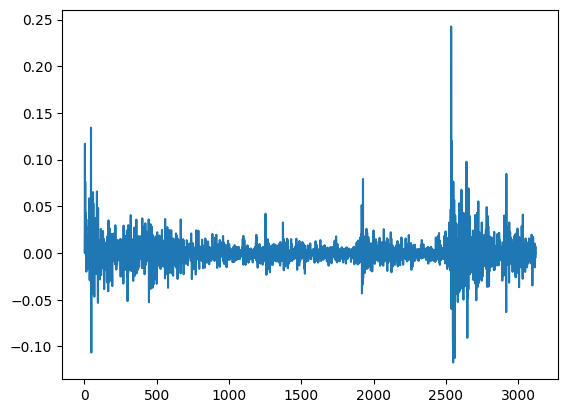

In [8]:
plt.plot(data["Cpct"])

In [9]:
data.Cpct.describe()

count    3121.000000
mean        0.000403
std         0.014560
min        -0.117105
25%        -0.004519
50%         0.000030
75%         0.004639
max         0.242588
Name: Cpct, dtype: float64

In [10]:
data["ohlc4"] = (data.close + data.open + data.high + data.low ) / 4
data["ohlc_pct"] = data["ohlc4"].pct_change()

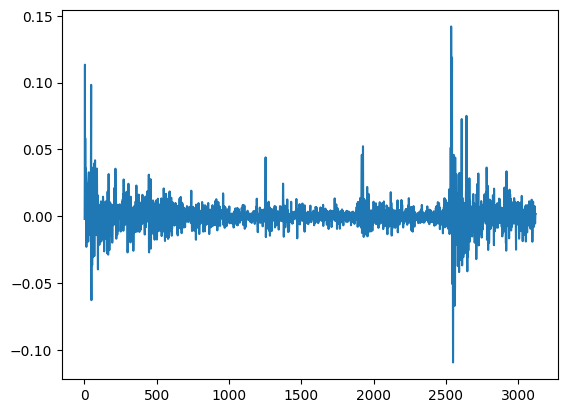

In [11]:
plt.plot(data.ohlc_pct)

In [12]:
data.ohlc_pct.describe()

count    3121.000000
mean        0.000355
std         0.010684
min        -0.109393
25%        -0.003432
50%         0.000048
75%         0.003859
max         0.141968
Name: ohlc_pct, dtype: float64

In [13]:
data["ma10"] = data.ohlc4.rolling(window= 10).mean()
data["ma10"].pct_change().describe()

count    3112.000000
mean        0.000263
std         0.004607
min        -0.029714
25%        -0.001415
50%        -0.000027
75%         0.001582
max         0.057540
Name: ma10, dtype: float64

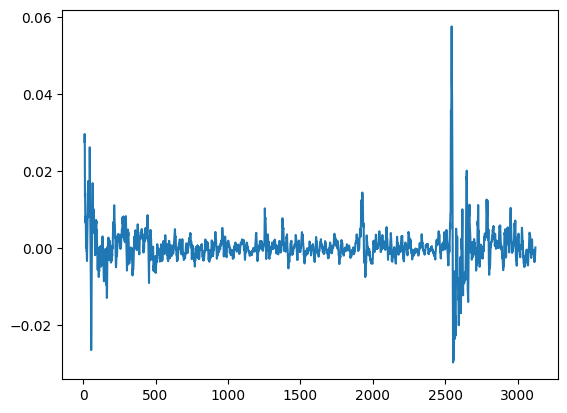

In [14]:
plt.plot(data["ma10"].pct_change())

In [15]:
data["ma200"] = data["ohlc4"].rolling(window=200).mean()

In [16]:
data["ma200"].pct_change().describe()

count    2922.000000
mean        0.000169
std         0.000805
min        -0.005538
25%        -0.000220
50%         0.000056
75%         0.000535
max         0.004150
Name: ma200, dtype: float64

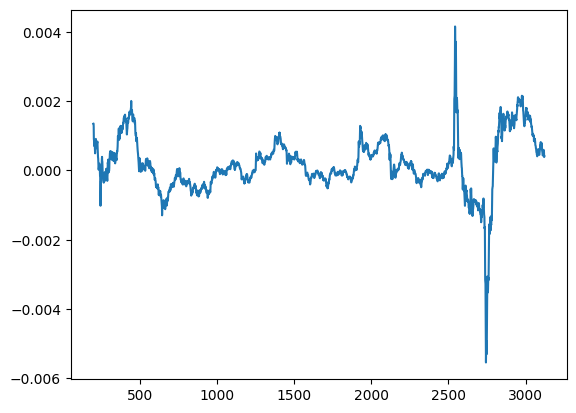

In [17]:
plt.plot(data["ma200"].pct_change())

In [18]:
fig = go.Figure(data=[go.Candlestick(x=data['date'],
                open=data['open'],
                high=data['high'],
                low=data['low'],
                close=data['close']),
                go.Scatter(mode="lines", x=data['date'], y=data["ma200"])])
fig.layout.yaxis.fixedrange = False
fig.show()

In [19]:
data["ma200_off"] = data["ma200"].shift(-100)

In [20]:
fig = go.Figure(data=[go.Candlestick(x=data['date'],
                open=data['open'],
                high=data['high'],
                low=data['low'],
                close=data['close']),
                go.Scatter(mode="lines", x=data['date'], y=data["ma200_off"])])
fig.layout.yaxis.fixedrange = False
fig.show()

In [21]:
sm.tsa.stattools.adfuller(data["Cdiff"].dropna())

(-13.040521437285244,
 2.2461707268089455e-24,
 25,
 3095,
 {'1%': -3.4324646145004256,
  '5%': -2.862474304424197,
  '10%': -2.567267353018705},
 9316.256267451343)

In [21]:
data["ew"] = data["ohlc4"].ewm(alpha=0.1).mean()

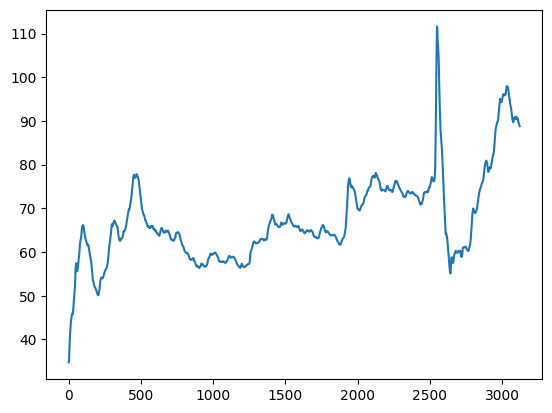

In [22]:
plt.plot(data["ew"])

In [23]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [24]:
model = SimpleExpSmoothing(data["ohlc4"])
# fit model
model_fit = model.fit(optimized=True)

In [25]:
print(model_fit.params)

{'smoothing_level': 0.9999999850988388, 'smoothing_trend': nan, 'smoothing_seasonal': nan, 'damping_trend': nan, 'initial_level': 34.780525, 'initial_trend': nan, 'initial_seasons': array([], dtype=float64), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


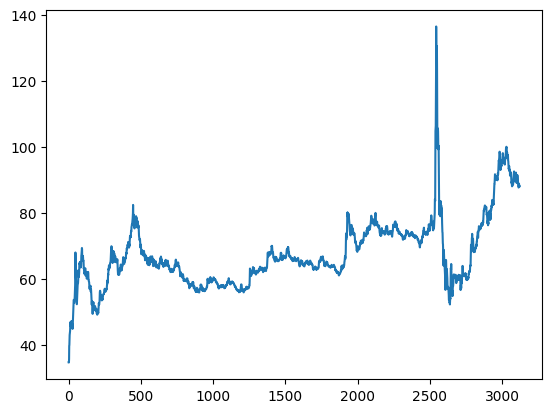

In [26]:
plt.plot(model_fit.fittedvalues)

(<Figure size 1000x200 with 1 Axes>, [<Axes: >])

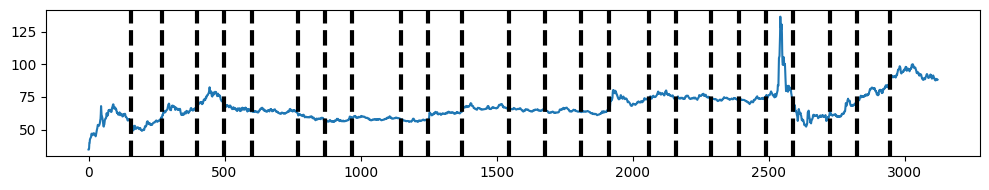

In [27]:
algo = rpt.Pelt(model="l2", min_size=100)
algo.fit(data[["ohlc4"]])
result = algo.predict(pen=1)

rpt.display(data["ohlc4"], [], result)

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data[["date","ohlc4"]], model='additive')
result.plot()
plt.show()

ValueError: could not convert string to float: '2014-02-06'

In [29]:
from datetime import datetime
dat = data[["date", "ohlc4"]]
dat["date"] = dat.apply(lambda row: datetime.strptime(row["date"], "%Y-%m-%d"), axis=1)
dat = dat.set_index("date")
dat = dat.asfreq('d').dropna()

C:\Users\igor\AppData\Local\Temp\ipykernel_10160\3410549196.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



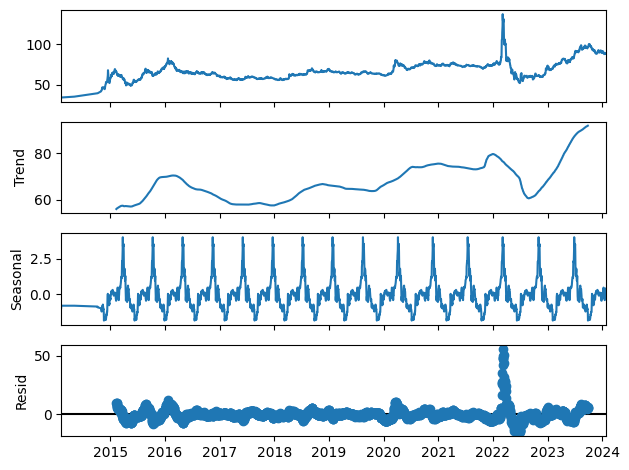

In [31]:
result = seasonal_decompose(dat, model='additive', period=200)
result.plot()
plt.show()